In [1]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 45kB/s 
     |████████████████████████████████| 4.3MB 55.6MB/s 
     |████████████████████████████████| 501kB 55.7MB/s 


In [2]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib
import cv2

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

tf.__version__

'2.0.0-rc1'

##  Data load(train, validation, test)

In [0]:
PATH = "/content/gdrive/My Drive/dataset"

train_dir = os.path.join(PATH, 'train_20')
validation_dir = os.path.join(PATH, 'val_20')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print(total_train)
print(total_val)
print(total_test)

##Visualize with each data graph

In [0]:
test_dir = pathlib.Path(test_dir)

CLASS_NAMES = np.array([item.name for item in test_dir.glob('*') if item.name != "LICENSE.txt"])

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  p1 = plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FFE6EB')
  p2 = plt.bar(x+0.15, dog, label='dog', width=0.3, color='#36E0C6')

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(cat[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(dog[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Dogs-vs-Cats Data')

  plt.show()
  return

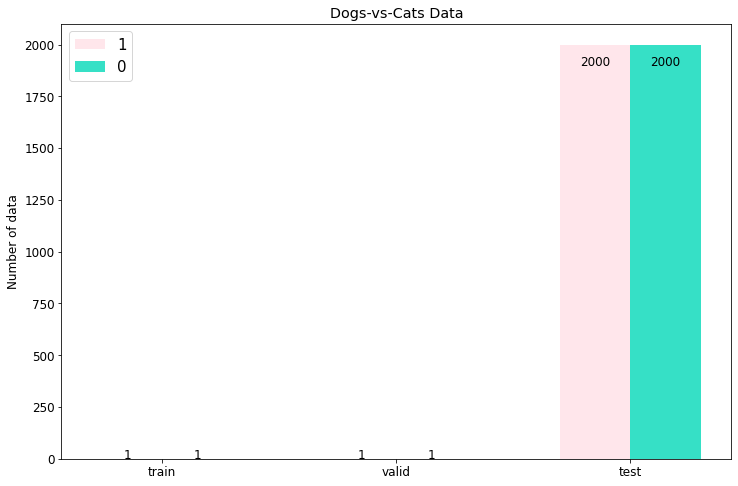

In [8]:
check_images(train_dir, validation_dir, test_dir)

##Hyperparameter initialization and dataset, load configuration

In [0]:
#하이퍼파라미터 초기화
batch_size = 20
epochs = 1
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=4,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 4 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=2,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2 images belonging to 2 classes.


In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              classes=list(CLASS_NAMES))

Found 4000 images belonging to 2 classes.


##Model design, detailed configuration of model-related parameters(optimization, loss function, metrics, etc.)

In [0]:
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')
def vgg16_model(input_data):
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_data)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2))(x)
 
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2))(x)

  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(input_data, x)

In [0]:
vggs = vgg16_model(input_tensor)

In [0]:
SGD = optimizers.SGD(lr=0.001, momentum=0.9)

vggs.compile(optimizer=SGD,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
vggs.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

##Model learning (with parameters such as checkpoints, steps, epochs, data, etc.)

In [0]:
history = vggs.fit_generator(
    train_data_gen,
    steps_per_epoch = 1,
    epochs=epochs,
    validation_data= val_data_gen,
    validation_steps=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1/1 [==============================] - 9s 9s/step - loss: 0.6933 - accuracy: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.5000


##View model learning graphs (1epochs)

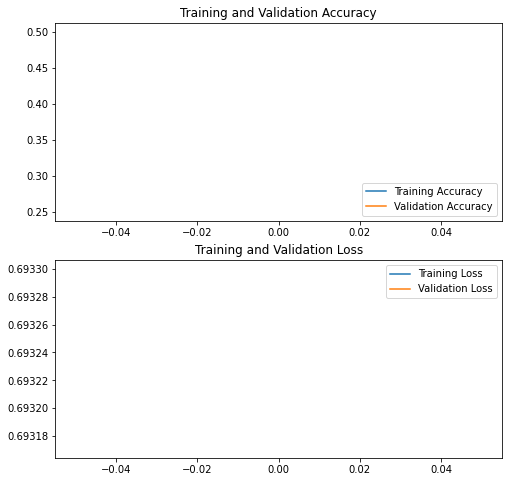

In [0]:
#epoch commit graph(train, validation - accracy, loss value)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Assess learning model and confirm prediction

In [0]:
#commit
print("Evaluate")
scores = vggs.evaluate_generator(test_data_gen, steps=200, verbose=1)
print("%s: %.2f%%" %(vggs.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(vggs.metrics_names[0], scores[0]*100))

Evaluate
200/200 [==============================] - 1171s 6s/step - loss: 0.6931 - accuracy: 0.5035
accuracy: 50.35%
loss: 69.31%


In [0]:
print("Predict")
pred = vggs.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 21s 105ms/step


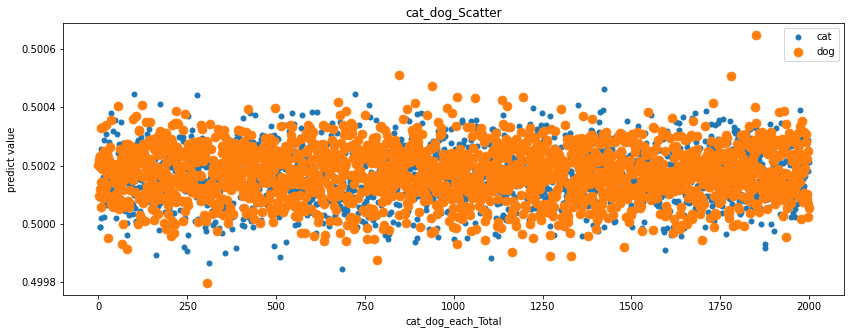

In [0]:
#test predict 예측값 분포도(4000개)

plt.figure(figsize=(14, 5))
plt.title('cat_dog_Scatter')
plt.xlabel('cat_dog_each_Total')
plt.ylabel('predict value')
plt.scatter(range(2000), pred[:2000], s=25, label = 'cat') #고양이
plt.scatter(range(2000), pred[2000:], s= 75, label = 'dog') #개
plt.legend()
plt.show()

In [0]:
#분류 작업

predict_data4 = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data4.append(1)
  else:
    predict_data4.append(0)

print(len(pred))

4000


Confusion Matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, 'true value')

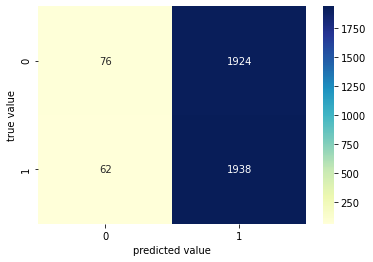

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data4)
#print(conf_matrix)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

##Feature map (one layer or one layer each).

(1, 224, 224, 3)


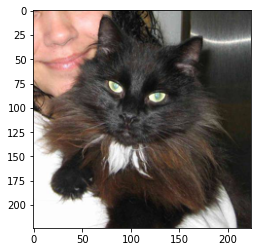

In [0]:
#feature map 


#test_image 한개 접근
test_image = Image.open('/content/gdrive/My Drive/dataset/test/cat/cat.89.jpg').resize((224, 224))

img_tensor = image.img_to_array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0


plt.imshow(test_image)

print(test_data.shape)

In [0]:
#모델 예측 확인
pred_test = vggs.predict(test_data)

print(pred_test)

[[0.49995697]]


In [0]:
feature_model = Sequential()

In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:19] if 'batch' != '{}'.format(layer.name[0:5])]
  output_names = [layer.name for layer in model.layers[1:19] if 'batch' != '{}'.format(layer.name[0:5])]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for pred_layer in show_model_pred:
    print(pred_layer.shape)
  return show_model_pred, output_names

In [0]:
layer_outputs, layer_names = Layer_predict(vggs, test_data)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)


In [0]:
def show_predict_image(show_model_pred,output_names):
    n_col= 16
    _, size2, size, n_features = show_model_pred.shape
    n_row = n_features //n_col
    # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
    feature_map_image = np.zeros(shape=(size2, size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

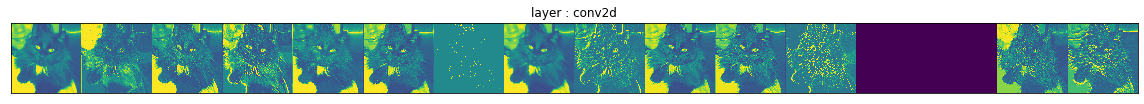

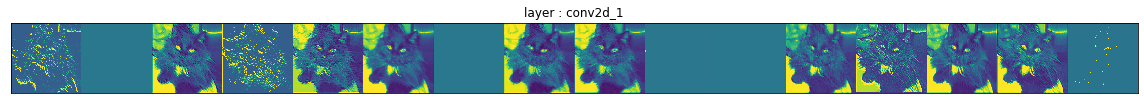

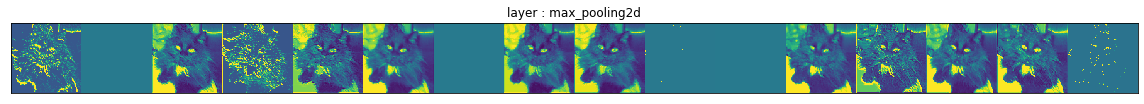

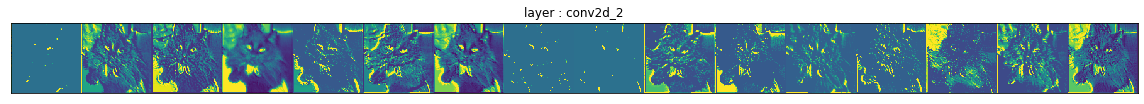

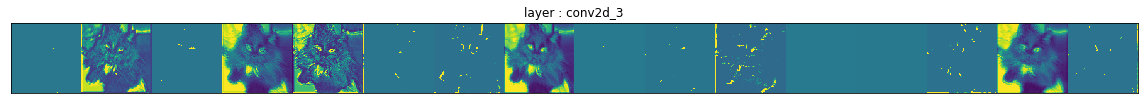

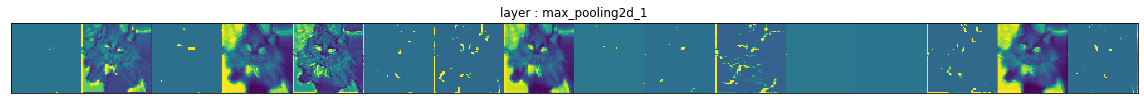

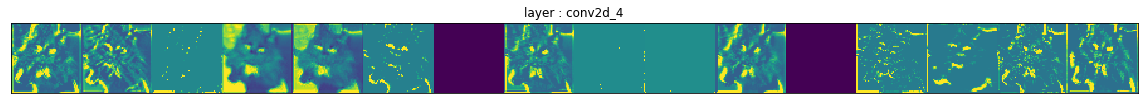

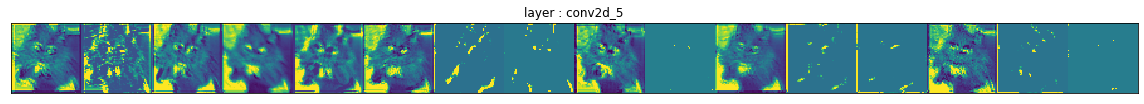

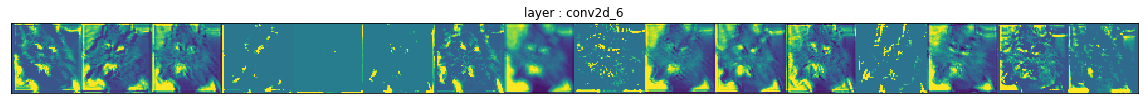

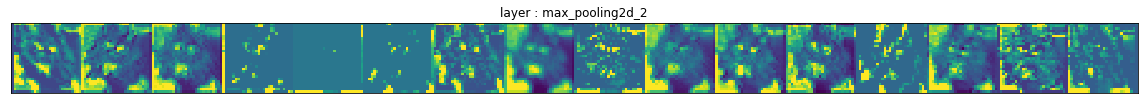

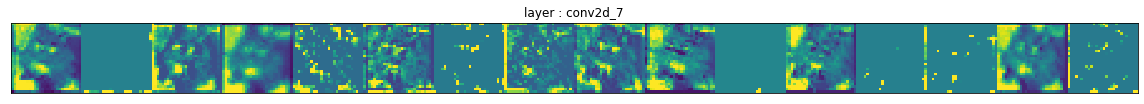

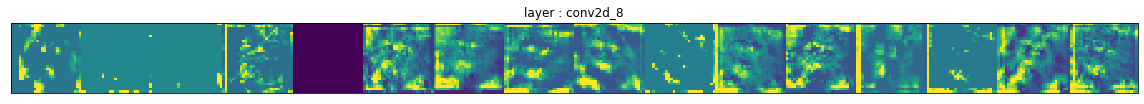

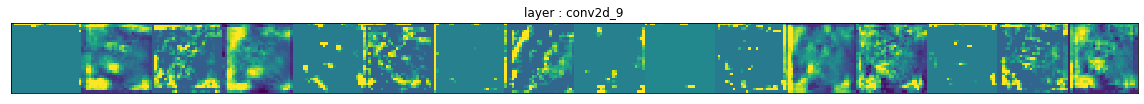

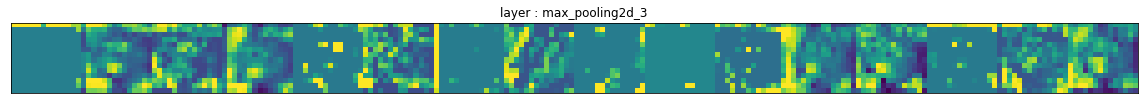

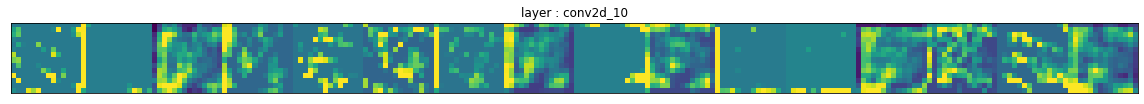

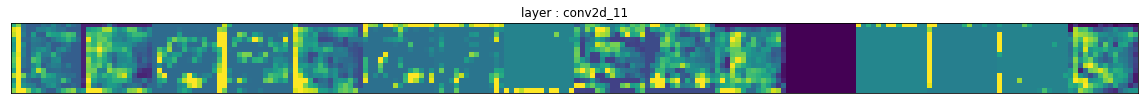

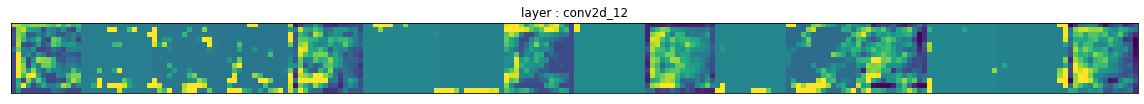

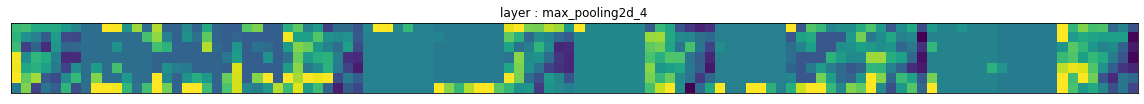

In [0]:
for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

In [0]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_maps(layer, title, i, n_cols=16):
  plt.subplot(2, 9, i+1)
  plt.title('{}:{}'.format(i, title))
  plt.axis('off')
  plt.matshow(layer[0, :, :, i], fignum=0)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


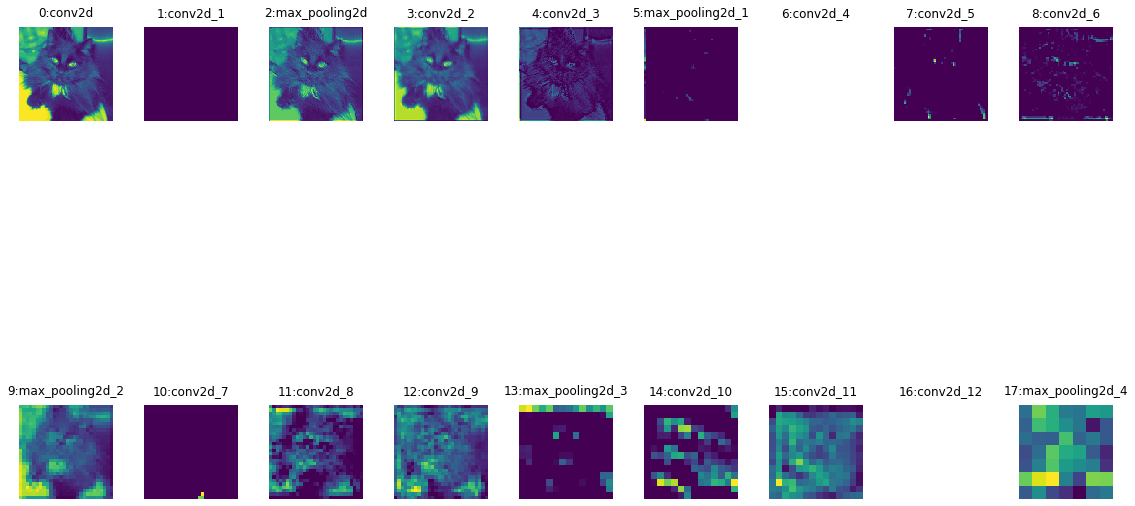

In [0]:
plt.figure(figsize=(16, 14))
for i, (layer, name) in enumerate(zip(layer_outputs, layer_names)):
  
  show_activation_maps(layer, name, i)
plt.tight_layout()
plt.show()

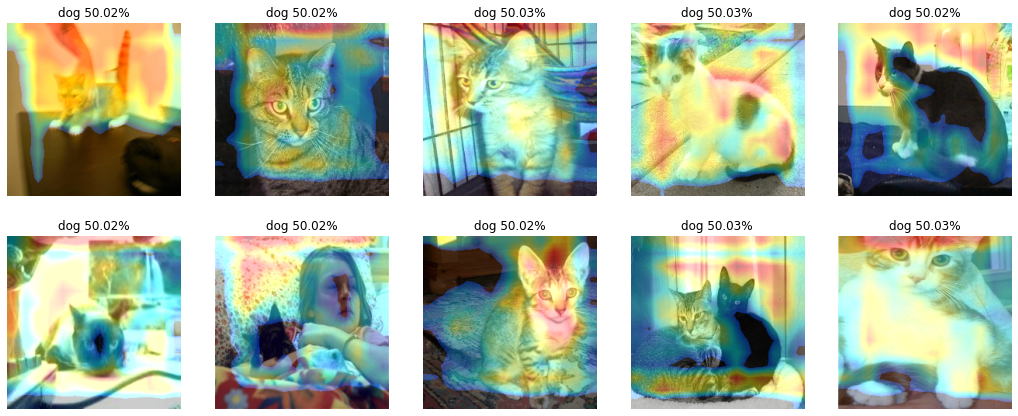

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vggs.inputs], [vggs.get_layer(index=16).output, vggs.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])

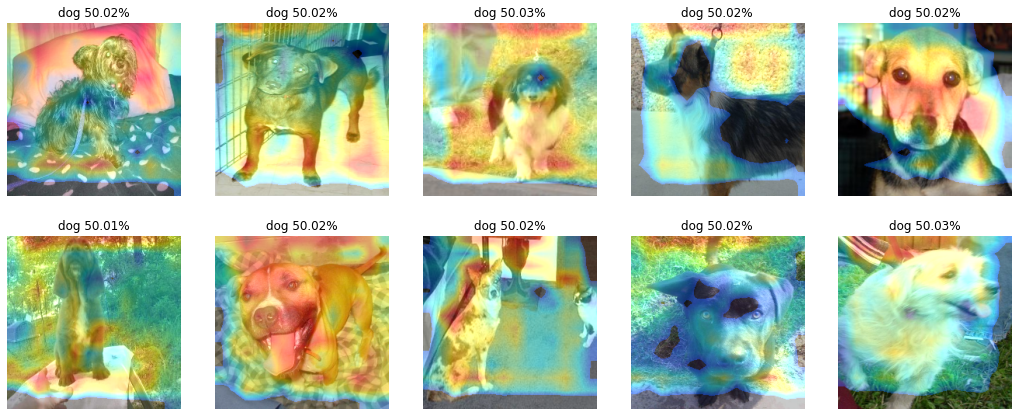

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/dog/dog.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vggs.inputs], [vggs.get_layer(index=16).output, vggs.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])